In [1]:
from datasets import load_dataset

data_files = {
    'train': '../data/ELI5/train.jsonl',
    'test': '../data/ELI5/val.jsonl'
}

dataset = load_dataset('json', data_files=data_files, streaming=True)

In [2]:
import polars as pl
from tqdm import tqdm

pl_dataset_details = pl.DataFrame(schema={'id':str, 'n_answers':int, 'n_contexts':int, 'training':bool})

for itr in tqdm(dataset['train'], leave=True):
    sample = pl.DataFrame({
        'id': [itr['question_id']],
        'n_answers': [len(itr['answers'])],
        'n_contexts': [len(itr['ctxs'])],
        'training': [True]
    })
    pl_dataset_details = pl.concat([pl_dataset_details, sample])

for itr in tqdm(dataset['test'], leave=True):
    sample = pl.DataFrame({
        'id': [itr['question_id']],
        'n_answers': [len(itr['answers'])],
        'n_contexts': [len(itr['ctxs'])],
        'training': [False]
    })
    pl_dataset_details = pl.concat([pl_dataset_details, sample])

print(pl_dataset_details.describe())

# analyse training set
print('Number of questions in train set:', pl.count(pl_dataset_details.filter(pl.col('training'))['id']))
print('Number of questions with no answers in train set:', pl.count(pl_dataset_details.filter(pl.col('training') & (pl.col('n_answers') == 0))['id']))
print('Number of questions with no contexts in train set:', pl.count(pl_dataset_details.filter(pl.col('training') & (pl.col('n_contexts') == 0))['id']))

# analyse test set
print('Number of questions in test set:', pl.count(pl_dataset_details.filter(pl.col('training') == False)['id']))
print('Number of questions with no answers in test set:', pl.count(pl_dataset_details.filter((pl.col('training') == False) & (pl.col('n_answers') == 0))['id']))
print('Number of questions with no contexts in test set:', pl.count(pl_dataset_details.filter((pl.col('training') == False) & (pl.col('n_contexts') == 0))['id']))

272634it [05:53, 772.15it/s] 
1507it [00:05, 291.66it/s]

shape: (9, 5)
┌────────────┬────────┬───────────┬────────────┬──────────┐
│ describe   ┆ id     ┆ n_answers ┆ n_contexts ┆ training │
│ ---        ┆ ---    ┆ ---       ┆ ---        ┆ ---      │
│ str        ┆ str    ┆ f64       ┆ f64        ┆ f64      │
╞════════════╪════════╪═══════════╪════════════╪══════════╡
│ count      ┆ 274141 ┆ 274141.0  ┆ 274141.0   ┆ 274141.0 │
│ null_count ┆ 0      ┆ 0.0       ┆ 0.0        ┆ 0.0      │
│ mean       ┆ null   ┆ 3.000036  ┆ 30.384802  ┆ 0.994503 │
│ std        ┆ null   ┆ 5.436227  ┆ 5.175728   ┆ 0.073939 │
│ min        ┆ 1000ju ┆ 1.0       ┆ 30.0       ┆ 0.0      │
│ max        ┆ zzzxq  ┆ 303.0     ┆ 100.0      ┆ 1.0      │
│ median     ┆ null   ┆ 2.0       ┆ 30.0       ┆ 1.0      │
│ 25%        ┆ null   ┆ 1.0       ┆ 30.0       ┆ null     │
│ 75%        ┆ null   ┆ 3.0       ┆ 30.0       ┆ null     │
└────────────┴────────┴───────────┴────────────┴──────────┘
Number of questions in train set: 272634
Number of questions with no answers in train 

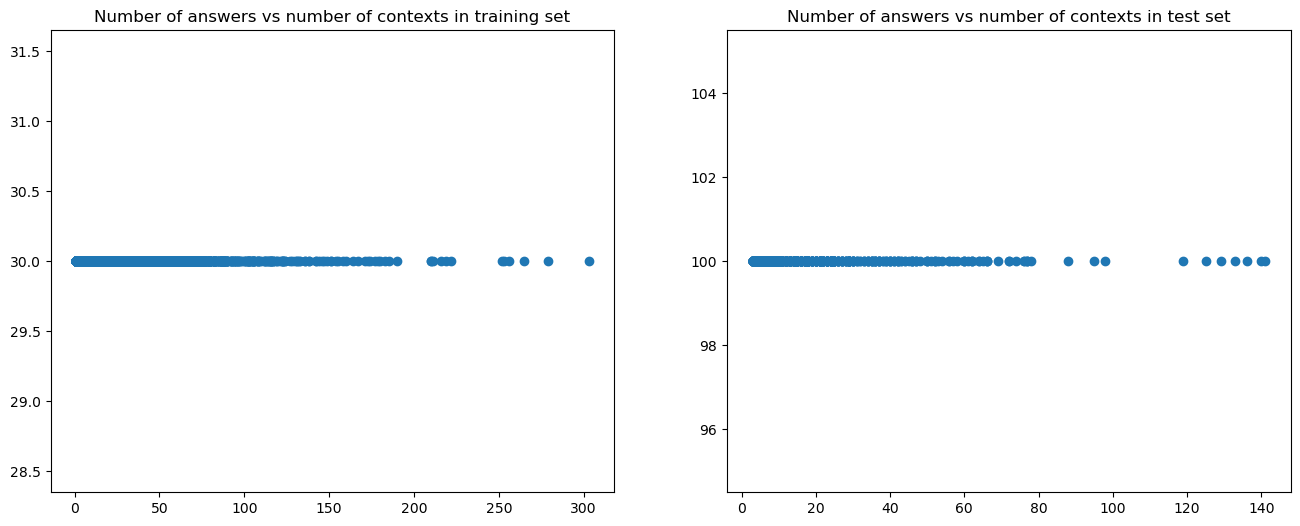

In [3]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

n_training_answers = pl_dataset_details.filter(pl.col('training'))['n_answers'].to_numpy()
n_training_contexts = pl_dataset_details.filter(pl.col('training'))['n_contexts'].to_numpy()
axs[0].scatter(n_training_answers, n_training_contexts)
axs[0].set_title('Number of answers vs number of contexts in training set')

n_test_answers = pl_dataset_details.filter(pl.col('training') == False)['n_answers'].to_numpy()
n_test_contexts = pl_dataset_details.filter(pl.col('training') == False)['n_contexts'].to_numpy()
axs[1].scatter(n_test_answers, n_test_contexts)
axs[1].set_title('Number of answers vs number of contexts in test set')

plt.show()